## Module loading and data preprocessing


#### Define my path

In [1]:
# Never change the path in the future!
MY_PATH = pwd()
@show MY_PATH
;

MY_PATH = "/home/bisardi/Dropbox/Research/Developing"


#### Upload packages

In [219]:
using Pkg
using FastaIO
using MultivariateStats
using Plots
using LinearAlgebra
using DelimitedFiles
using StatsBase
import Plots.abline!
include(joinpath(MY_PATH, "../Basic_code/StuffDCA/src/energy.jl"))
include(joinpath(MY_PATH, "../Basic_code/StuffDCA/src/read_write.jl"))
include(joinpath(MY_PATH, "../Basic_code/StuffDCA/src/msa_tools.jl"))
include(joinpath(MY_PATH, "../Basic_code/SeqsEvol/developing/evol.jl"))
;

#### Functions

In [234]:
function plot_seq_PCA(seq, pc_comp, M; name = "PCA nat", name_seq = "seq")
    
    M_data_nat = size(pc_comp)[2]
    
    p_nat = histogram2d(
    pc_comp[1, :],
    pc_comp[2, :],
    bins = (collect(-50:1:50), collect(-50:1:50)),
    xlabel = "z1",
    ylabel = "z2",
    title = "$name",
    labelfontsize = 10,
    xlims = [-50, 50],
    ylims = [-50, 50],
    color = :viridis,
    framestyle = :box,
    size = (600, 500)
    )


    pc_seq = transform(M, Float64.(seq))

    plot!(p_nat, 
    pc_seq[1, :],
    pc_seq[2, :],
    color = :red,
    seriestype = :scatter,
    markersize = 5,
    label = "$name_seq"
    )

    return p_nat
end


function find_best_mut_pos(ref_seq, target_seq, list_muts, h, J)
    ens = []
    for pos in list_muts
        seq = deepcopy(ref_seq)
        seq[pos] = target_seq[pos] 
        append!(ens, compute_energy_single_sequence(h, J, seq))
    end
    return list_muts[findmin(ens)[2]]
end


;



function find_best_mut_pos_double(ref_seq, target_seq, list_muts, h, J)
    seq = deepcopy(ref_seq)
    ll = length(list_muts)
    ens = []
    couples =  [[] for i in 1:Int16( ll*(ll - 1)/2 )]
    k = 1
    
    for (i, pos1) in enumerate(list_muts[1 : (end - 1)])
        for pos2 in list_muts[i + 1, end]  
            seq = deepcopy(ref_seq)
            seq[ [pos1, pos2]      ] = target_seq[ [pos1, pos2]  ]
            couples[k] = [pos1, pos2]
            append!(ens, compute_energy_single_sequence(h, J, seq))
            k += 1
        end
    end    
    indexit = findmin(ens)[2]
    return couples[indexit]
end


function energy_pca(pc, en)

    histo = fit(Histogram, 
        (pc[2, :],
         pc[1, :]),
        Weights(  Float64.(en)  ),
        (-50:1:50, -50:1:50),
        )

    histo_base = fit(Histogram, 
        (pc[2, :],
         pc[1, :]),
        (-50:1:50, -50:1:50))

    hm = heatmap(string.(collect(histo.edges[1])),
    string.(collect(histo.edges[2])),
    histo.weights./histo_base.weights,
    xlabel = "z1",
    ylabel = "z2",
    title = "",
    labelfontsize = 10,
    label = "",
    color = :Spectral_4,
    framestyle = :box,
    size = (800,600)
    )
    return hm
end

;


#### Upload alis

In [4]:
ali_nat = fasta2matrix(joinpath(MY_PATH, "../Data/PF13354/ali/Beta-lactamase2.wo_ref_seqs.ali"))
;

#### Learn the model

In [5]:
M = fit(PCA, Float64.(ali_nat'), maxoutdim = 2)
;

#### Get the components of the natural sequences

In [9]:
pc_nat = transform(M, Float64.(ali_nat)')
;

#### Import DCA parameters

In [10]:
PATH_PAR = joinpath(MY_PATH,"../Data/PF13354/par/Parameters_conv_Pierre.dat" )
h,J = read_par_BM(PATH_PAR, 21, 202)

PATH_PAR = joinpath(MY_PATH,"../Data/PF13354/par/Parameters_conv_decPierre.dat" )
h_dec,J_dec = read_par_BM(PATH_PAR, 21, 202)
;

## Visualize transition paths

#### Test

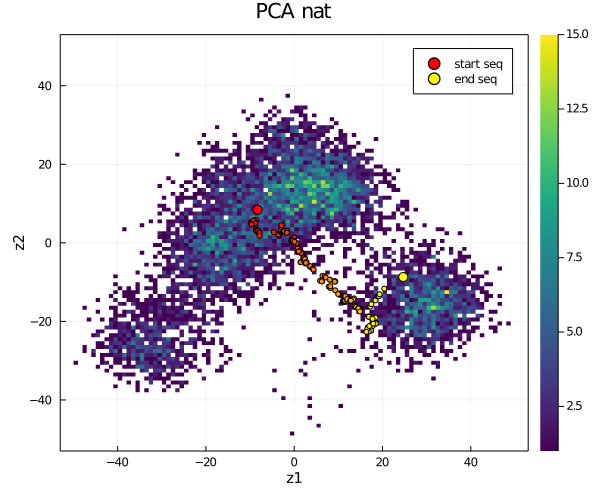

In [115]:
start_seq = ali_nat[100, :]
end_seq = ali_nat[2800, :]

h_d = count_muts(start_seq, end_seq)
cc = palette([:red, :yellow], h_d)


pp = plot_seq_PCA(start_seq, pc_nat, M, name_seq = "start seq")


seq = deepcopy(start_seq)
for i in 1:h_d
    pos_m = get_pos_muts(start_seq, end_seq)
    seq[pos_m[i]] = end_seq[pos_m[i]]
    pc_seq = transform(M, Float64.(seq))
    plot!(pp, pc_seq[1, :], pc_seq[2, :], seriestype = :scatter, color = cc[i], markersize = 3, label = "")
end



pc_seq = transform(M, Float64.(end_seq))
plot!(pp, pc_seq[1, :], pc_seq[2, :], seriestype = :scatter, color = :yellow, markersize = 5, label = "end seq")

display(pp)
;

#### Energies and greedy paths

In [235]:
tem1 = fasta2matrix(joinpath(MY_PATH, "../Data/PF13354/ref/TEM-1_fantini_pfam.fa"))[1, :]

en_ref = compute_energy_single_sequence(h, J, tem1)
en = [compute_energy_single_sequence(h, J, ali_nat[i, :]) - en_ref for i in 1:size(ali_nat, 1)]
;

In [125]:
histo = fit(Histogram, 
    (pc_nat[2, :],
    pc_nat[1, :]),
    Weights(  Float64.(en)  ),
    (-50:1:50, -50:1:50),
    )

histo_base = fit(Histogram, 
    (pc_nat[2, :],
    pc_nat[1, :]),
    (-50:1:50, -50:1:50))
;


In [199]:
start_seq = ali_nat[5460, :]
end_seq = ali_nat[2860, :]


h_d = count_muts(start_seq, end_seq)
cc = palette([:blue, :violet], h_d)


## Random
pos_m = get_pos_muts(start_seq, end_seq)

pc1_t = []
pc2_t = []

#seqs = start_seq

seq = deepcopy(start_seq)
for i in 1:h_d
    mut_here =  rand(pos_m)
    seq[mut_here] = end_seq[mut_here]
    pc_seq = transform(M, Float64.(seq))
    append!(pc1_t, pc_seq[1] + 50)
    append!(pc2_t, pc_seq[2] + 50)
    
    #seqs = hcat(seqs, seq)
    
    #plot!(hm, [pc_seq[1] + 50], [pc_seq[2] + 50], seriestype = :scatter, color = cc[i], markersize = 3, label = "")
    pos_m = deleteat!(pos_m, findfirst(x->x == mut_here , pos_m))
end




## Greedy single mut
pos_m = get_pos_muts(start_seq, end_seq)

pc1 = []
pc2 = []

seq = deepcopy(start_seq)
for i in 1:h_d
    mut_here =  find_best_mut_pos(seq, end_seq, pos_m, h, J)
    seq[mut_here] = end_seq[mut_here]
    pc_seq = transform(M, Float64.(seq))
    append!(pc1, pc_seq[1] + 50)
    append!(pc2, pc_seq[2] + 50)
    #plot!(hm, [pc_seq[1] + 50], [pc_seq[2] + 50], seriestype = :scatter, color = cc[i], markersize = 3, label = "")
    pos_m = deleteat!(pos_m, findfirst(x->x == mut_here , pos_m))
end


## greedy double mut
pos_m = get_pos_muts(start_seq, end_seq)

pc1_d = []
pc2_d = []


seq = deepcopy(start_seq)
ll = isodd(h_d) ? Int16( (h_d - 1)/2 ) : Int16(h_d/2)
for i in 1:ll
    muts_here =  find_best_mut_pos_double(seq, end_seq, pos_m, h, J)
    seq[muts_here] = end_seq[muts_here]
    pc_seq = transform(M, Float64.(seq))
    append!(pc1_d, pc_seq[1] + 50)
    append!(pc2_d, pc_seq[2] + 50)
    pos_m = deleteat!(pos_m, findfirst(x->x == muts_here[1] , pos_m))
    pos_m = deleteat!(pos_m, findfirst(x->x == muts_here[2] , pos_m))
end
;

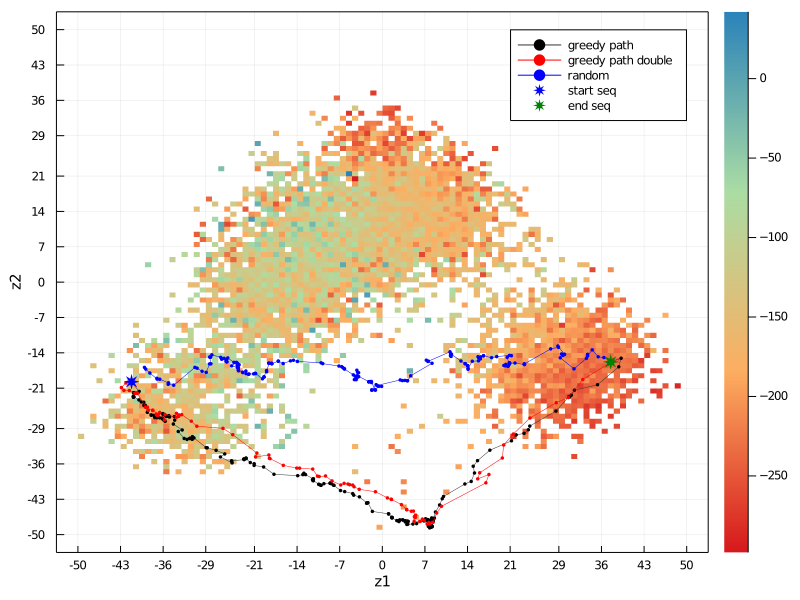

In [201]:
hm = heatmap(string.(collect(histo.edges[1])),
    string.(collect(histo.edges[2])),
    histo.weights./histo_base.weights,
    xlabel = "z1",
    ylabel = "z2",
    title = "",
    labelfontsize = 10,
    label = "test",
    color = :Spectral_4,
    framestyle = :box,
    size = (800,600)
)

plot!(hm,  pc1, pc2, markercolor = :black, marker = :circle ,markersize = 2, label = "greedy path", linestyle = :solid, 
    linewidth = 0.5, markerstrokewidth = 0, linecolor = :grey20)

plot!(hm,  pc1_d, pc2_d, markercolor = :red, marker = :circle ,markersize = 2, label = "greedy path double", linestyle = :solid, 
    linewidth = 0.5, markerstrokewidth = 0, linecolor = :red)


#pc1_t = transform(M, Float64.(seqs))[1, :] .+51
#pc2_t = transform(M, Float64.(seqs))[2, :] .+50

plot!(hm,  pc1_t, pc2_t, markercolor = :blue, marker = :circle ,markersize = 2, label = "random", linestyle = :solid, 
    linewidth = 0.5, markerstrokewidth = 0, linecolor = :blue)


pc_seq = transform(M, Float64.(start_seq))
c1_s = pc_seq[1] + 50
c2_s = pc_seq[2] + 50
plot!(hm,  [c1_s], [c2_s], seriestype = :scatter, color = :blue, markersize = 8, label = "start seq", 
    markerstrokewidth  = 0, marker = :star8)


pc_seq = transform(M, Float64.(end_seq))
c1 = pc_seq[1] + 50
c2 = pc_seq[2] + 50
plot!(hm, [c1], [c2], seriestype = :scatter, color = :green, markersize = 8, label = "end seq",  
    markerstrokewidth = 0, marker = :star8)



display(hm)

#### MC sampling

In [395]:
start_seq = ali_nat[5460, :]

sampled_seqs = start_seq
new = start_seq
for i in 1:1000
    new = evol_seq_fix_steps(new, 5, h, J, T = 0.01)
    sampled_seqs = hcat(sampled_seqs, new)
end


pc = transform(M, Float64.(sampled_seqs))
pc1 = pc[1, :] .+50 
pc2 = pc[2, :] .+50 
;


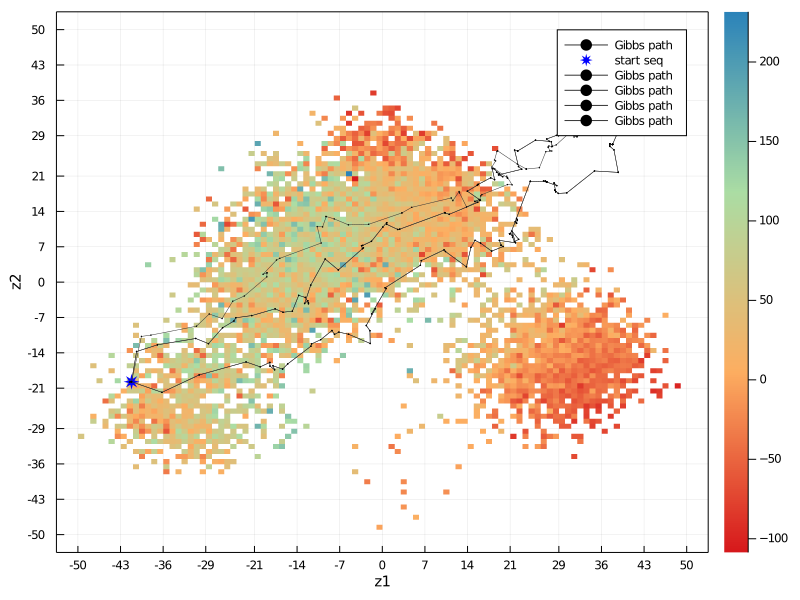

In [397]:
#pp = energy_pca(pc_nat, en)


plot!(pp,  pc1, pc2, markercolor = :black, marker = :circle ,markersize = 1, label = "Gibbs path", legendposition = :topleft,
    linestyle = :solid, linewidth = 0.5, markerstrokewidth = 0, linecolor = :grey20)


pc_seq = transform(M, Float64.(start_seq))
c1_s = pc_seq[1] + 50
c2_s = pc_seq[2] + 50
#plot!(pp,  [c1_s], [c2_s], seriestype = :scatter, color = :blue, markersize = 8, label = "start seq", 
#    markerstrokewidth  = 0, marker = :star8)

display(pp)

#### T = 0.1

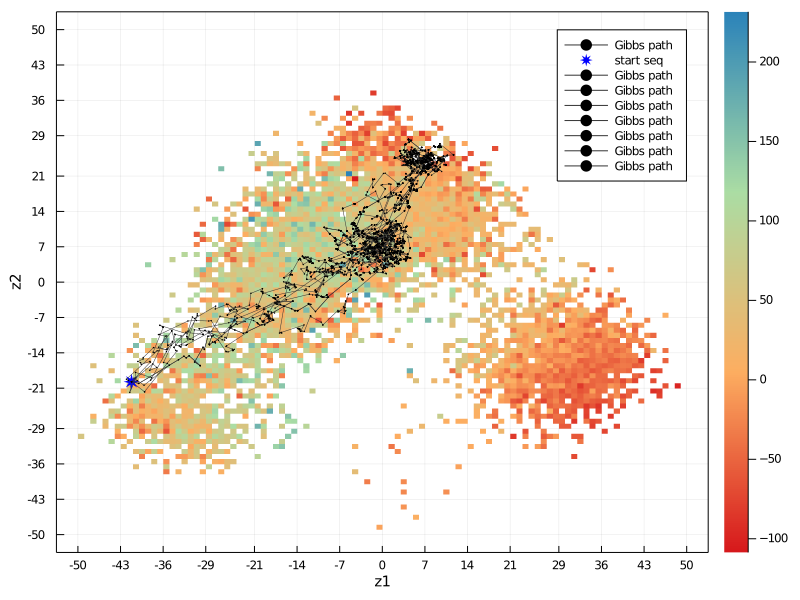